# Data Visualization And Training Models
## In this notebook the preprocessed data are visualized on charts and ML models are learned. Furthermore model with the best statistic measure (for example accuracy) is picked to save into file.

## 1. Install necessary libraries

In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from feature_extraction.feature_extraction import FeatureExtraction
from feature_extraction.utils import PatternCollector
from utils.measure_time import measure_time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, log_loss
from utils.plot_two_cat import PlotTwoCat
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall, AUC

## 2. Load preprocessed data from files

In [2]:
path_to_phish_data_file = os.path.join('preprocessed_data', 'phish_data.csv')
path_to_well_known = os.path.join('preprocessed_data', 'well_known.csv')
path_to_non_phish_data_longer = os.path.join('preprocessed_data', 'non_phish_data_longer.csv')
path_to_non_phish_data_shorter = os.path.join('preprocessed_data', 'non_phish_data_shorter.csv')

In [3]:
df1_phish = pd.read_csv(path_to_phish_data_file, index_col='Unnamed: 0', encoding='utf-8')
df1_phish.rename(columns={'PHISH_URL': 'URL'}, inplace=True)

In [4]:
df1_phish.head()

,URL,label
0,https://ollx.1792836.xyz/captcha,1
1,https://ufakick456.com/captcha,1
2,https://keyeseuropean.com/captcha,1
3,https://allegr0lokalnie.83473636.xyz/captcha,1
4,http://ufakick456.com/fb7pl5qw,1


In [5]:
df2_non_phish = pd.read_csv(path_to_non_phish_data_shorter, index_col='Unnamed: 0')
df2_non_phish.rename(columns={'NON_PHISH_URL': 'URL'}, inplace=True)

In [6]:
df2_non_phish.head()

,URL,label
0,https://releases.jquery.com/,0
1,https://code.jquery.com/,0
2,https://app.ether.fi/blocked,0
3,https://efty.com/d/2zfr2/NeonClaims.com/,0
4,https://www.yahoo.com/?&sid=74508,0


In [7]:
df_well_known = pd.read_csv(path_to_well_known, index_col='Unnamed: 0')
df_well_known

,URL,label
443571,https://www.google.com,0
443572,https://www.facebook.com,0
443573,https://www.youtube.com,0
443574,https://www.wp.pl,0
443575,https://www.google.pl,0
...,...,...
443981,https://www.adobe.com/products/xd.html,0
443982,https://www.invisionapp.com,0
443983,https://www.sketch.com,0
443984,https://www.gimp.org,0


### 2.1 Check the data shape:

In [8]:
df1_phish.shape

(154832, 2)

In [9]:
df2_non_phish.shape

(443946, 2)

In [10]:
df_merged = pd.concat([df1_phish, df2_non_phish])
df_merged

,URL,label
0,https://ollx.1792836.xyz/captcha,1
1,https://ufakick456.com/captcha,1
2,https://keyeseuropean.com/captcha,1
3,https://allegr0lokalnie.83473636.xyz/captcha,1
4,http://ufakick456.com/fb7pl5qw,1
...,...,...
443981,https://www.adobe.com/products/xd.html,0
443982,https://www.invisionapp.com,0
443983,https://www.sketch.com,0
443984,https://www.gimp.org,0


### 2.2 Merge data:

In [11]:
df_merged.shape

(598778, 2)

### 2.3 Drop duplicates:

In [12]:
df_merged.nunique()

URL      598637
label         2
dtype: int64

In [13]:
df_merged[df_merged['URL'].duplicated()]

,URL,label
5654,https://solcold.com/,0
5655,http://solcold.com/,0
5656,https://darkhost.pro:443/,0
5740,https://ciet-itac.ca/fr/user/login,0
5751,http://sistema.gavadent.com/admin/site/login,0
...,...,...
443572,https://www.facebook.com,0
443573,https://www.youtube.com,0
443583,https://www.instagram.com,0
443609,https://www.google.com.br,0


In [14]:
df_merged['URL'].duplicated().sum()

141

In [15]:
df_merged.drop_duplicates(subset=['URL'], inplace=True, keep=False)

In [16]:
df_merged.nunique()

URL      598496
label         2
dtype: int64

### 2.4 Check new shape:

In [17]:
df_merged.shape

(598496, 2)

## 3. Take equal number of rows from both DataFrames (equal distribution of labels)

In [18]:
ONE_CLASS_SET_SIZE = 50_000

### 3.1 Sample rows with label equal 1:

In [19]:
label1_filter = df_merged['label'] == 1
df_urls_1 = df_merged[label1_filter].sample(ONE_CLASS_SET_SIZE)

In [20]:
df_urls_1.shape

(50000, 2)

In [21]:
df_urls_1.groupby('label').count()

,URL
label,
1,50000


### 3.2 Sample rows with label equal 0:

In [22]:
WELL_KNOWN_SIZE = 414
df_urls_2 = df_well_known.sample(WELL_KNOWN_SIZE)
df_urls_2

,URL,label
443637,https://www.centrum24.pl,0
443883,https://www.hundredninetythree.fit,0
443854,https://www.hundredsixtyfour.diet,0
443951,https://www.pluralsight.com/browse/software-de...,0
443799,https://www.hundrednine.international,0
...,...,...
443961,https://www.gitlab.com,0
443801,https://www.hundredeleven.cool,0
443863,https://www.hundredseventythree.education,0
443615,https://www.mbank.pl,0


In [23]:
label0_filter = df_merged['label'] == 0
df_urls_2 = pd.concat([df_merged[label0_filter].sample(ONE_CLASS_SET_SIZE - WELL_KNOWN_SIZE), df_urls_2])

In [24]:
df_urls_2.tail()

,URL,label
443961,https://www.gitlab.com,0
443801,https://www.hundredeleven.cool,0
443863,https://www.hundredseventythree.education,0
443615,https://www.mbank.pl,0
443890,https://www.twohundred.forsale,0


In [25]:
df_urls_2.shape

(50000, 2)

In [26]:
df_urls_2.groupby('label').count()

,URL
label,
0,50000


### 3.3 Merge DataFrames into one frame:

In [27]:
df_urls = pd.concat([df_urls_1, df_urls_2])

In [28]:
df_urls.shape

(100000, 2)

In [29]:
df_urls.groupby('label').count()

,URL
label,
0,50000
1,50000


In [30]:
df_urls.head()

,URL,label
121669,www.dymatec.com/index.htm,1
33825,https://home-102407.weeblysite.com/,1
35443,https://cloudflare-ipfs.com/ipfs/bafybeihbolvd...,1
13414,https://tinyurl.com/yckhsuy6,1
54759,https://bit.ly/3L8CIpr,1


In [31]:
df_urls.tail()

,URL,label
443961,https://www.gitlab.com,0
443801,https://www.hundredeleven.cool,0
443863,https://www.hundredseventythree.education,0
443615,https://www.mbank.pl,0
443890,https://www.twohundred.forsale,0


### 3.4 Shuffle probes in the set:

In [32]:
df_urls = df_urls.sample(len(df_urls))

In [33]:
df_urls.head(10)

,URL,label
382344,https://http://hollywoodlife.com/2015/05/13/ju...,0
111770,www.jbviande.com/uk/default.asp,1
118650,www.igi-pub.com/journals/details.asp?id=198,1
339406,https://encycl.opentopia.com/G/GI/GIL,0
61576,paypal.com.ecoteh.org,1
63415,https://en.wikipedia.org/wiki/Matson_Navigatio...,0
94589,http://livecalgary.com/smbc.co.jp/jp/jp/smbc.c...,1
181477,https://slayground.livejournal.com/459114.html,0
229650,https://facebook.com/CowJonesVegan,0
2836,https://pub-5c4547c9d3ff42149784914ba0d33a6a.r...,1


In [34]:
df_urls.tail(10)

,URL,label
39018,https://ipfs.eth.aragon.network/ipfs/bafybeicr...,1
80836,notification2017.000webhostapp.com,1
94890,https://tinyurl.com/ycmh8yaq,1
70318,lostiphonefinder-lcloud.review,1
351453,https://thepiratebay.org/torrent/3408806/Xena_...,0
59503,https://bafybeicny6wvjulotaburyrkd4jao2gltxipx...,1
92472,http://u722323ssw.ha004.t.justns.ru/dossier/,1
57325,https://toaconsulting.com/rcu.org/,1
176383,https://uky.edu/KentuckyAtlas/21111.html,0
238712,https://gowalla.com/spots/612756,0


In [35]:
df_urls.shape

(100000, 2)

In [36]:
df_urls.groupby('label').count()

,URL
label,
0,50000
1,50000


### 3.5 Check for nulls:

In [37]:
df_urls['URL'].isnull().sum()

0

In [38]:
df_urls['URL'].isnull().sum()

0

### 3.6 Plot distribution of the data:

In [39]:
labels_counts = df_urls['label'].value_counts()
label_desc = labels_counts.index
labels_counts

label
0    50000
1    50000
Name: count, dtype: int64

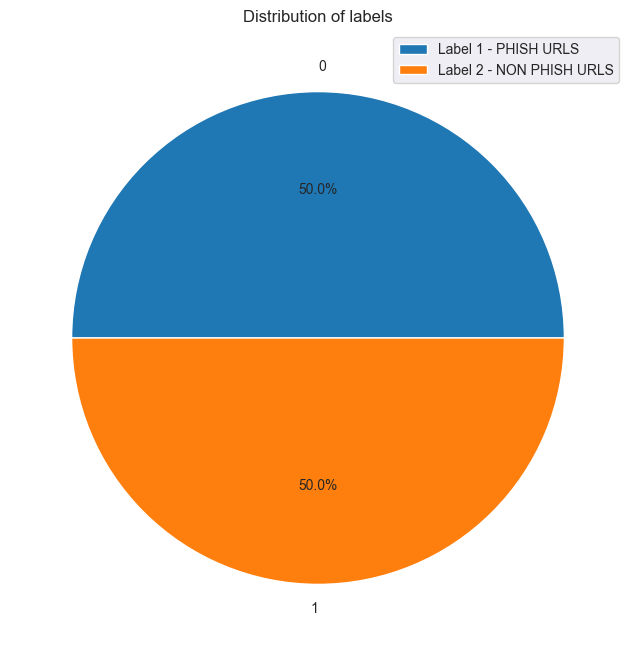

In [40]:
plt.figure(figsize=(8, 8))
plt.pie(labels_counts, labels=label_desc, autopct='%1.1f%%')
plt.title("Distribution of labels")
plt.legend(['Label 1 - PHISH URLS', 'Label 2 - NON PHISH URLS'], loc='upper right')
plt.show()

## 4. Save sampled urls to file

### 4.1 Save to file

In [41]:
df_urls.to_csv(os.path.join('sampled_data', 'sampled_data50to50.csv'), encoding='utf-8')

### 4.2 Save to file

In [42]:
df_urls = pd.read_csv(os.path.join('sampled_data', 'sampled_data50to50.csv'), encoding='utf-8')
df_urls

,Unnamed: 0,URL,label
0,382344,https://http://hollywoodlife.com/2015/05/13/ju...,0
1,111770,www.jbviande.com/uk/default.asp,1
2,118650,www.igi-pub.com/journals/details.asp?id=198,1
3,339406,https://encycl.opentopia.com/G/GI/GIL,0
4,61576,paypal.com.ecoteh.org,1
...,...,...,...
99995,59503,https://bafybeicny6wvjulotaburyrkd4jao2gltxipx...,1
99996,92472,http://u722323ssw.ha004.t.justns.ru/dossier/,1
99997,57325,https://toaconsulting.com/rcu.org/,1
99998,176383,https://uky.edu/KentuckyAtlas/21111.html,0


In [43]:
df_urls.rename(columns={'Unnamed: 0': 'OLD_INDEX'}, inplace=True)
df_urls

,OLD_INDEX,URL,label
0,382344,https://http://hollywoodlife.com/2015/05/13/ju...,0
1,111770,www.jbviande.com/uk/default.asp,1
2,118650,www.igi-pub.com/journals/details.asp?id=198,1
3,339406,https://encycl.opentopia.com/G/GI/GIL,0
4,61576,paypal.com.ecoteh.org,1
...,...,...,...
99995,59503,https://bafybeicny6wvjulotaburyrkd4jao2gltxipx...,1
99996,92472,http://u722323ssw.ha004.t.justns.ru/dossier/,1
99997,57325,https://toaconsulting.com/rcu.org/,1
99998,176383,https://uky.edu/KentuckyAtlas/21111.html,0


## 5. Extract features with previously created methods and add them to DataFrame

### 5.1 Get length of url:

In [44]:
df_urls['URL_LENGTH'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).url_length if FeatureExtraction(url).url_length <= 1000 else 1000)

In [45]:
df_urls.head()

,OLD_INDEX,URL,label,URL_LENGTH
0,382344,https://http://hollywoodlife.com/2015/05/13/ju...,0,98
1,111770,www.jbviande.com/uk/default.asp,1,31
2,118650,www.igi-pub.com/journals/details.asp?id=198,1,43
3,339406,https://encycl.opentopia.com/G/GI/GIL,0,37
4,61576,paypal.com.ecoteh.org,1,21


In [46]:
grouped_by_length = df_urls[['URL_LENGTH', 'URL']].groupby(['URL_LENGTH']).count()
grouped_by_length.tail()

,URL
URL_LENGTH,
935,1
950,1
967,1
975,1
1000,13


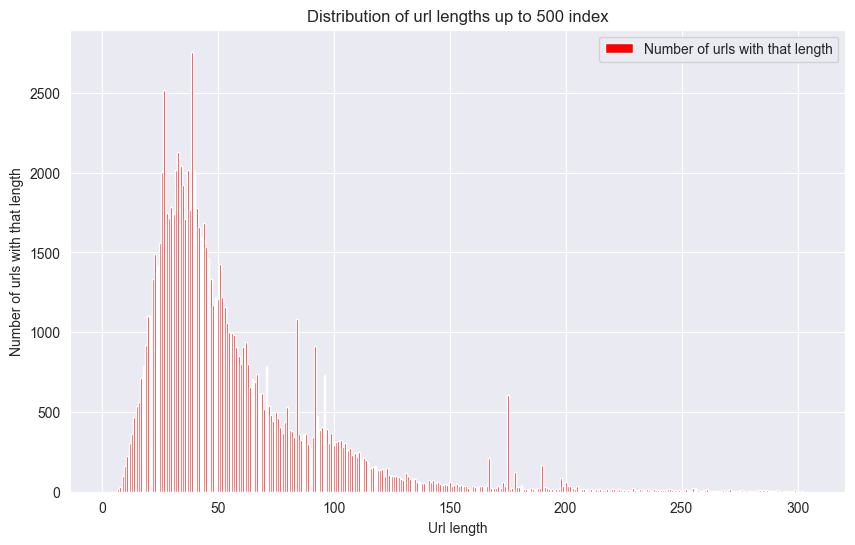

In [47]:
plt.figure(figsize=(10, 6))
plt.bar(grouped_by_length.index[:300], grouped_by_length['URL'][:300], color='red')
plt.title("Distribution of url lengths up to 500 index")
plt.xlabel("Url length")
plt.ylabel("Number of urls with that length")
plt.legend(['Number of urls with that length'], loc='upper right')
plt.show()

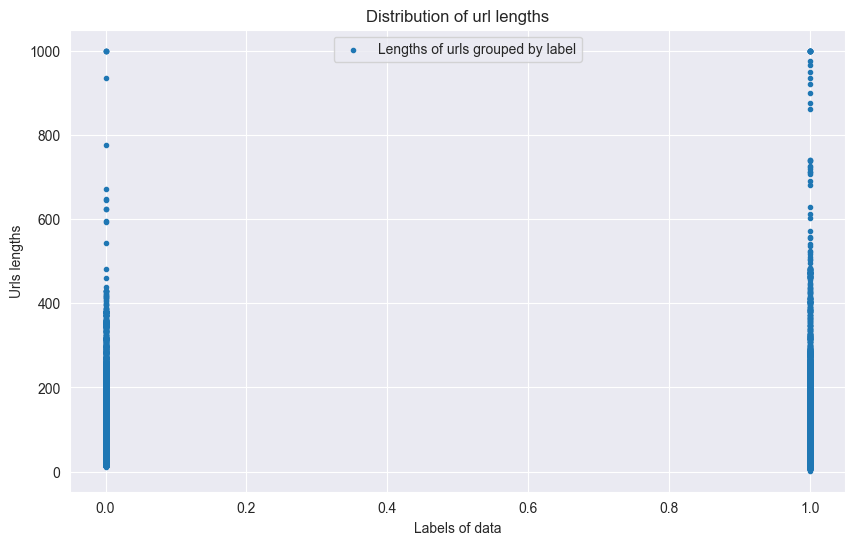

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['URL_LENGTH'], marker='.')
plt.title("Distribution of url lengths")
plt.xlabel("Labels of data")
plt.ylabel("Urls lengths")
plt.legend(['Lengths of urls grouped by label'], loc='upper center')
plt.show()

### 5.2 Check if URL has @ sign (Commented out because this parameter is redundant  - later the number of @ occurrences is counted):

In [49]:
# df_urls['HAVE_@'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_at_sign() else 0)

In [50]:
# legitimate_and_have_at_filter = (df_urls['HAVE_@'] == 1) & (df_urls['label'] == 0)
# legitimate_and_not_have_at_filter = (df_urls['HAVE_@'] == 0) & (df_urls['label'] == 0)
# phish_and_have_at_filter = (df_urls['HAVE_@'] == 1) & (df_urls['label'] == 1)
# phish_and_not_have_at_filter = (df_urls['HAVE_@'] == 0) & (df_urls['label'] == 1)
# 
# values1 = [len(df_urls[legitimate_and_have_at_filter]), len(df_urls[legitimate_and_not_have_at_filter])]
# values2 = [len(df_urls[phish_and_have_at_filter]), len(df_urls[phish_and_not_have_at_filter])]

In [51]:
# PlotTwoCat(
#     positive_cat='HAVE @',
#     negative_cat='DO NOT HAVE @',
#     title='Bar plot of having @ sign in URL',
#     pos_values=values1,
#     neg_values=values2
# ).plot_by_categories()

### 5.3 Check if URL has IP address instead of domain name:

In [52]:
df_urls['HAVE_IP'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_ip_address() else 0)

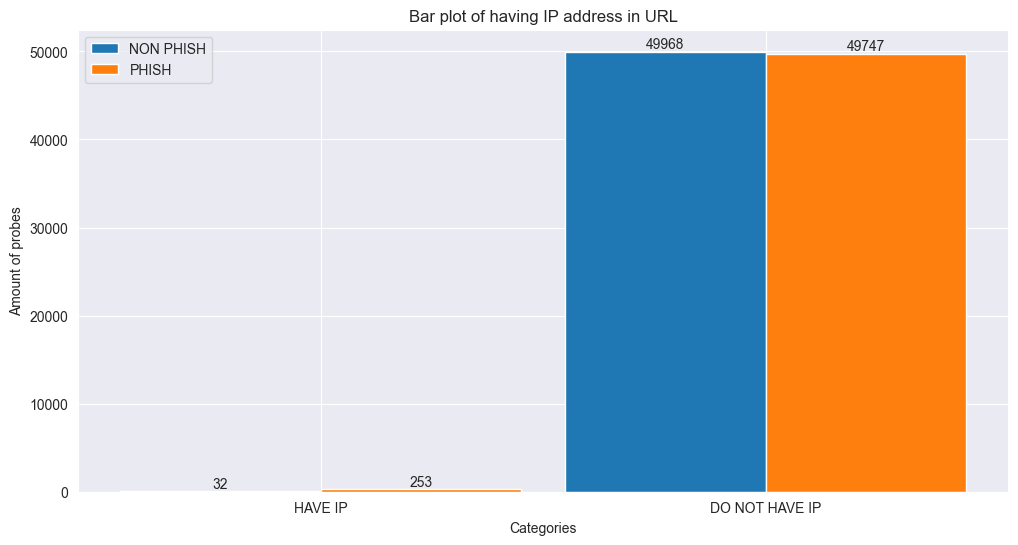

In [53]:
# Filter results
legitimate_and_have_ip_filter = (df_urls['HAVE_IP'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_have_ip_filter = (df_urls['HAVE_IP'] == 0) & (df_urls['label'] == 0)
phish_and_have_ip_filter = (df_urls['HAVE_IP'] == 1) & (df_urls['label'] == 1)
phish_and_not_have_ip_filter = (df_urls['HAVE_IP'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_have_ip_filter]), len(df_urls[legitimate_and_not_have_ip_filter])]
values2 = [len(df_urls[phish_and_have_ip_filter]), len(df_urls[phish_and_not_have_ip_filter])]

PlotTwoCat(
    positive_cat='HAVE IP',
    negative_cat='DO NOT HAVE IP',
    title='Bar plot of having IP address in URL',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.4 Check if URL is shorter than mean length in set:

In [54]:
mean_url_length = (df_urls['URL'].apply(lambda url: len(url)).sum()/len(df_urls['URL'])).__floor__()
print(f"Mean URL length: {mean_url_length} chars")

Mean URL length: 58 chars


In [55]:
df_urls['LONGER_THAN_MEAN'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).url_longer_than(mean_url_length) else 0)

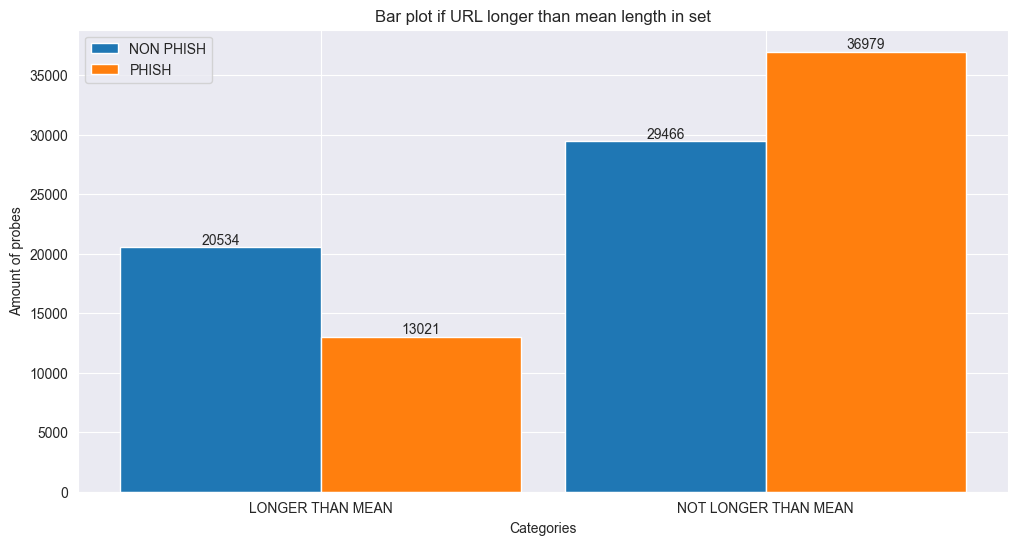

In [56]:
# Filter results
legitimate_and_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 0) & (df_urls['label'] == 0)
phish_and_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 1) & (df_urls['label'] == 1)
phish_and_not_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_longer_than_mean_filter]), len(df_urls[legitimate_and_not_longer_than_mean_filter])]
values2 = [len(df_urls[phish_and_longer_than_mean_filter]), len(df_urls[phish_and_not_longer_than_mean_filter])]

PlotTwoCat(
    positive_cat='LONGER THAN MEAN',
    negative_cat='NOT LONGER THAN MEAN',
    title='Bar plot if URL longer than mean length in set',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.5 Collect chars from URL:

In [57]:
@measure_time
def collect_chars() -> pd.DataFrame:
    chars_df = pd.DataFrame()
    for c in PatternCollector.chars:
        chars_df[c] = pd.DataFrame.from_dict(df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_characters().get(c)))
    return chars_df

In [58]:
df = collect_chars()

Measured running time of collect_chars: 0:00:55.983805


In [59]:
print(df.shape)
df.head()

(100000, 32)


,!,@,#,$,%,^,&,*,(,),...,<,>,?,/,+,=,-,_,',""""
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,6,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,2,0,1,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df_urls = pd.merge(df_urls, df, left_index=True, right_index=True, how='inner')
print(df_urls.shape)
df_urls.head()

(100000, 38)


,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,<,>,?,/,+,=,-,_,',""""
0,382344,https://http://hollywoodlife.com/2015/05/13/ju...,0,98,0,1,0,0,0,0,...,0,0,0,9,0,0,6,0,0,0
1,111770,www.jbviande.com/uk/default.asp,1,31,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
2,118650,www.igi-pub.com/journals/details.asp?id=198,1,43,0,0,0,0,0,0,...,0,0,1,2,0,1,1,0,0,0
3,339406,https://encycl.opentopia.com/G/GI/GIL,0,37,0,0,0,0,0,0,...,0,0,0,5,0,0,0,0,0,0
4,61576,paypal.com.ecoteh.org,1,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


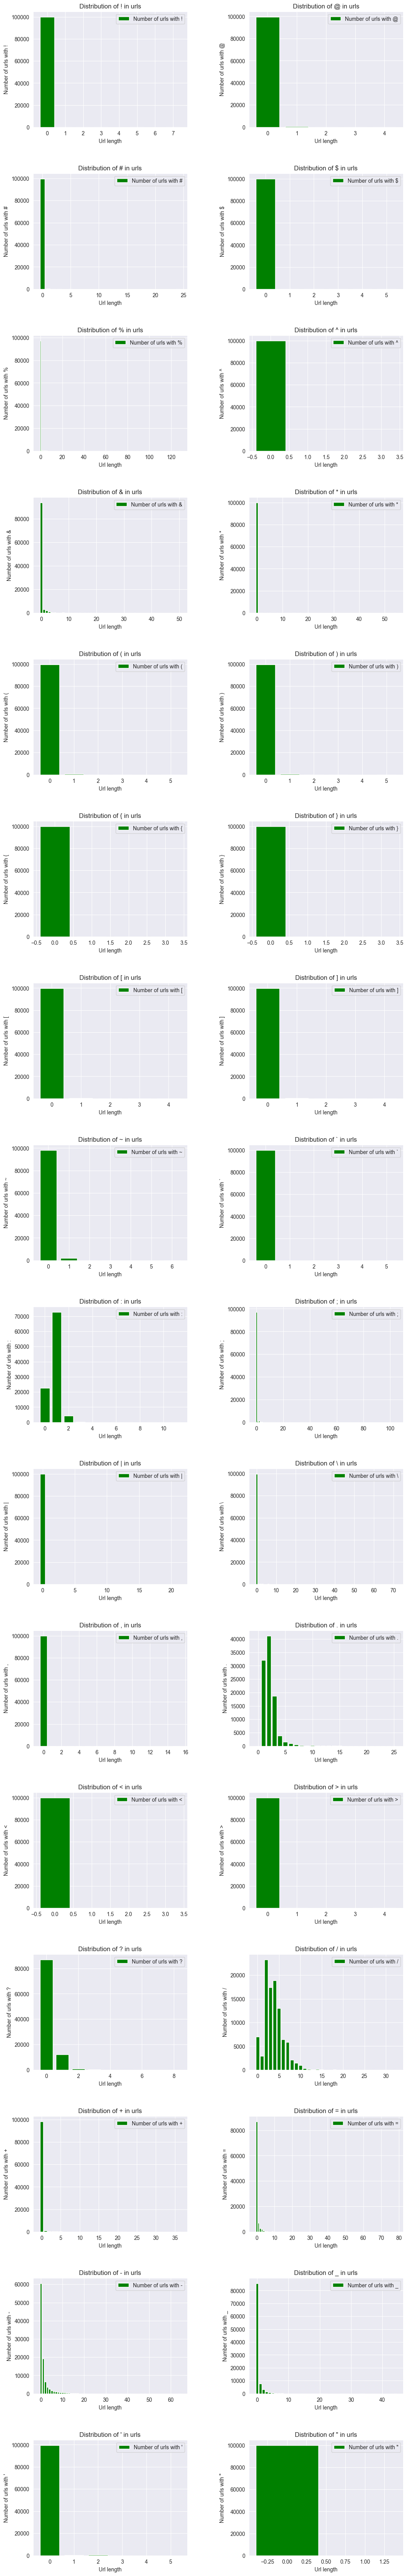

In [61]:
plt.figure(figsize=(12, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
for pos, char in enumerate(PatternCollector.chars):    
    grouped_by_char = df_urls[[char, 'URL']].groupby([char]).count()
    plt.subplot(16, 2, pos+1)
    plt.bar(grouped_by_char.index, grouped_by_char['URL'], color='green', )
    plt.title(f"Distribution of {char} in urls")
    plt.xlabel("Url length")
    plt.ylabel(f"Number of urls with {char}")
    plt.legend([f'Number of urls with {char}'], loc='upper right')

plt.show()

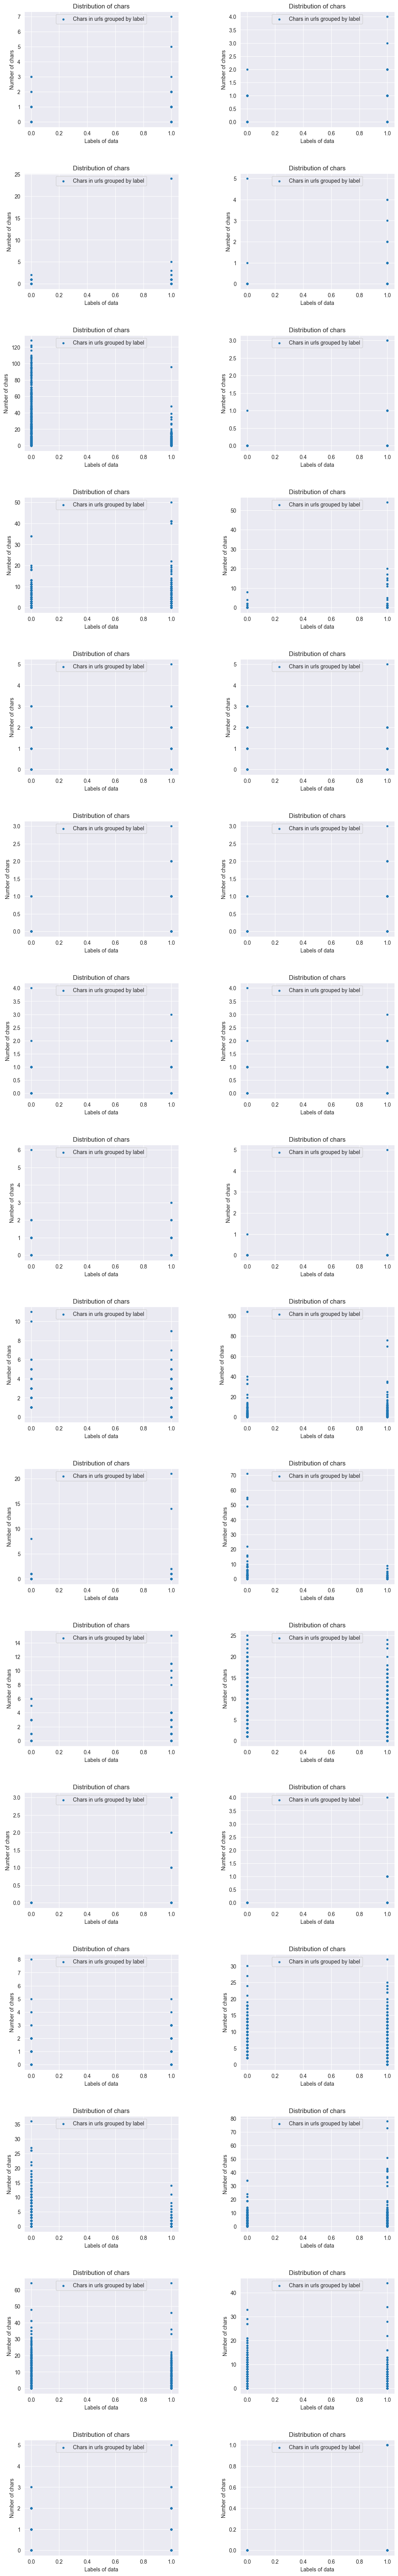

In [62]:
plt.figure(figsize=(12, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
for pos, char in enumerate(PatternCollector.chars):    
    grouped_by_char = df_urls[[char, 'URL']].groupby([char]).count()
    plt.subplot(16, 2, pos+1)
    plt.scatter(df_urls['label'], df_urls[char], marker='.')
    plt.title("Distribution of chars")
    plt.xlabel("Labels of data")
    plt.ylabel("Number of chars")
    plt.legend(['Chars in urls grouped by label'], loc='upper center')

plt.show()

In [63]:
# Count chars and drop that columns in which there are zero chars in any url
for ch in PatternCollector.chars:
    print(f"Number of urls with an once '{ch}': {df_urls[df_urls[ch] != 0][ch].count()}")
    zero_chars_in_set = df_urls[df_urls[ch] != 0][ch].count() == 0
    if zero_chars_in_set:
        df_urls = df_urls.drop(ch, axis=1)


Number of urls with an once '!': 49
Number of urls with an once '@': 552
Number of urls with an once '#': 382
Number of urls with an once '$': 25
Number of urls with an once '%': 2819
Number of urls with an once '^': 11
Number of urls with an once '&': 6200
Number of urls with an once '*': 38
Number of urls with an once '(': 491
Number of urls with an once ')': 491
Number of urls with an once '{': 48
Number of urls with an once '}': 48
Number of urls with an once '[': 183
Number of urls with an once ']': 188
Number of urls with an once '~': 1893
Number of urls with an once '`': 11
Number of urls with an once ':': 77407
Number of urls with an once ';': 2903
Number of urls with an once '|': 22
Number of urls with an once '\': 431
Number of urls with an once ',': 132
Number of urls with an once '.': 99978
Number of urls with an once '<': 10
Number of urls with an once '>': 9
Number of urls with an once '?': 13125
Number of urls with an once '/': 93000
Number of urls with an once '+': 1779

### 5.6 Check if url has https scheme:

In [64]:
df_urls['HAVE_HTTPS'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_https() else 0)

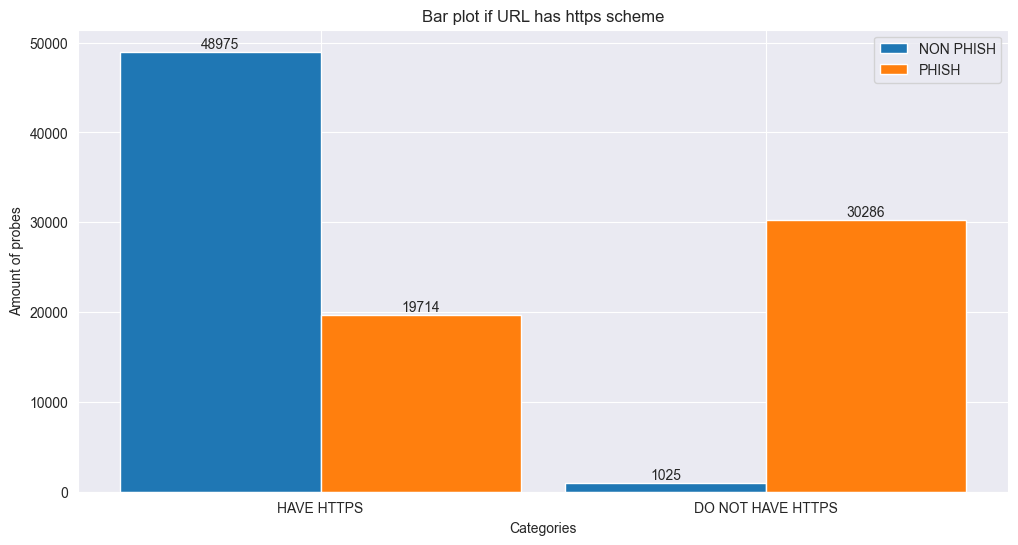

In [65]:
# Filter results
legitimate_and_https_filter = (df_urls['HAVE_HTTPS'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_https_filter = (df_urls['HAVE_HTTPS'] == 0) & (df_urls['label'] == 0)
phish_and_https_filter = (df_urls['HAVE_HTTPS'] == 1) & (df_urls['label'] == 1)
phish_and_not_https_filter = (df_urls['HAVE_HTTPS'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_https_filter]), len(df_urls[legitimate_and_not_https_filter])]
values2 = [len(df_urls[phish_and_https_filter]), len(df_urls[phish_and_not_https_filter])]

PlotTwoCat(
    positive_cat='HAVE HTTPS',
    negative_cat='DO NOT HAVE HTTPS',
    title='Bar plot if URL has https scheme',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.7 Check if url is abnormal:

In [66]:
df_urls['ABNORMAL_URL'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).abnormal_url else 0)

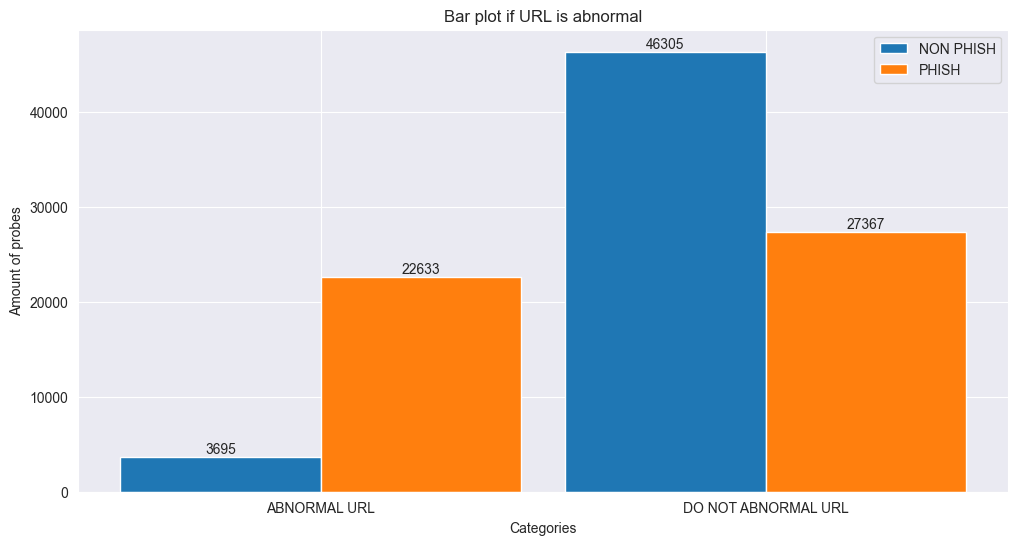

In [67]:
# Filter results
legitimate_and_abnormal_filter = (df_urls['ABNORMAL_URL'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_abnormal_filter = (df_urls['ABNORMAL_URL'] == 0) & (df_urls['label'] == 0)
phish_and_abnormal_filter = (df_urls['ABNORMAL_URL'] == 1) & (df_urls['label'] == 1)
phish_and_not_abnormal_filter = (df_urls['ABNORMAL_URL'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_abnormal_filter]), len(df_urls[legitimate_and_not_abnormal_filter])]
values2 = [len(df_urls[phish_and_abnormal_filter]), len(df_urls[phish_and_not_abnormal_filter])]

PlotTwoCat(
    positive_cat='ABNORMAL URL',
    negative_cat='DO NOT ABNORMAL URL',
    title='Bar plot if URL is abnormal',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

### 5.8 Count how many digits in the url:

In [68]:
df_urls['DIGITS_AMOUNT'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_digits() if FeatureExtraction(url).count_digits() <= 500 else 500)

In [69]:
counted_digits = df_urls[['URL', 'DIGITS_AMOUNT']].groupby('DIGITS_AMOUNT').count()
counted_digits.tail()

,URL
DIGITS_AMOUNT,
284,2
289,1
290,1
404,1
500,2


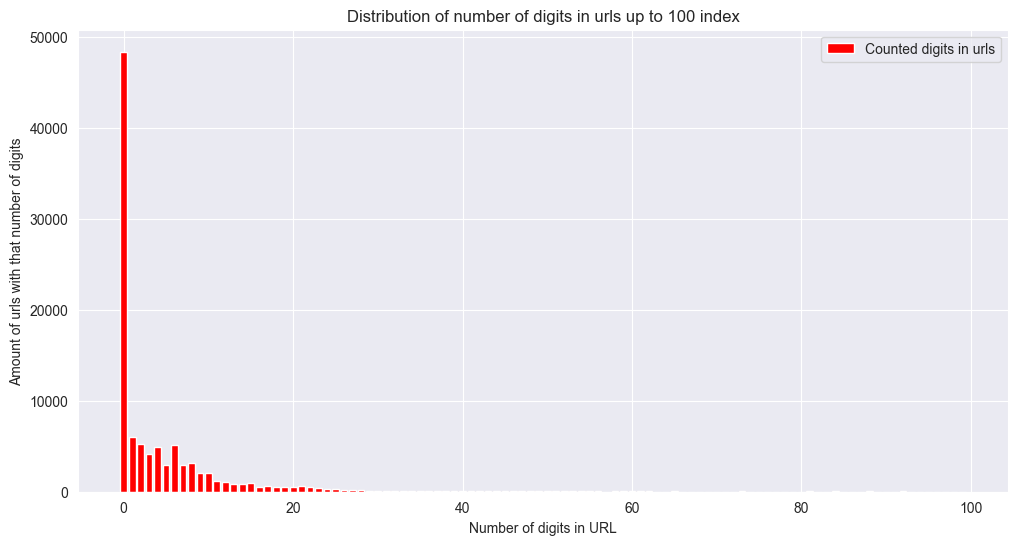

In [70]:
plt.figure(figsize=(12, 6))
plt.bar(counted_digits.index[:100], counted_digits['URL'][:100], color='r')
plt.title('Distribution of number of digits in urls up to 100 index')
plt.xlabel('Number of digits in URL')
plt.ylabel('Amount of urls with that number of digits')
plt.legend(['Counted digits in urls'], loc='best')
plt.show()

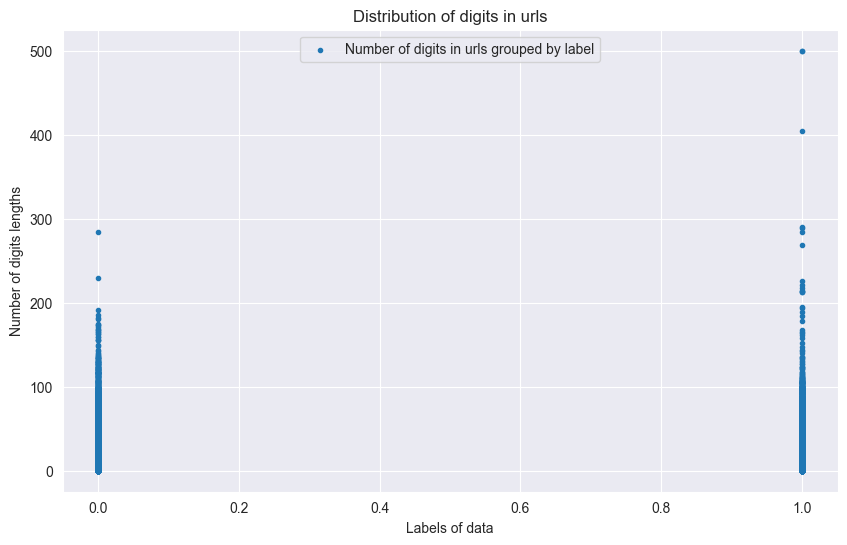

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['DIGITS_AMOUNT'], marker='.')
plt.title("Distribution of digits in urls")
plt.xlabel("Labels of data")
plt.ylabel("Number of digits lengths")
plt.legend(['Number of digits in urls grouped by label'], loc='upper center')
plt.show()

### 5.9 Count how many letters in url:

In [72]:
df_urls['LETTERS_AMOUNT'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_letters() if FeatureExtraction(url).count_letters() <= 500 else 500)

In [73]:
counted_letters = df_urls[['URL', 'LETTERS_AMOUNT']].groupby('LETTERS_AMOUNT').count()
counted_letters.tail()

,URL
LETTERS_AMOUNT,
476,1
479,1
484,1
498,1
500,28


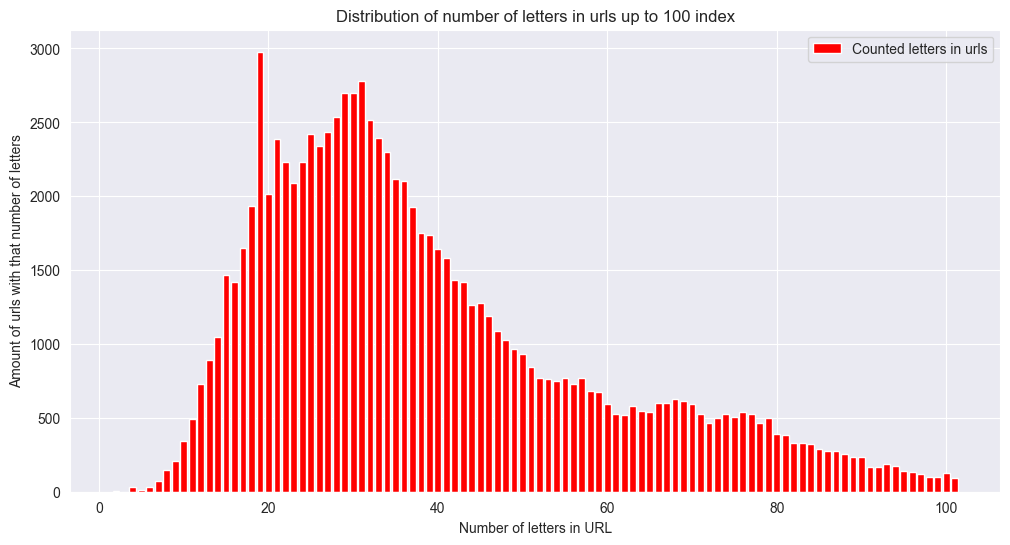

In [74]:
plt.figure(figsize=(12, 6))
plt.bar(counted_letters.index[:100], counted_letters['URL'][:100], color='r')
plt.title('Distribution of number of letters in urls up to 100 index')
plt.xlabel('Number of letters in URL')
plt.ylabel('Amount of urls with that number of letters')
plt.legend(['Counted letters in urls'], loc='best')
plt.show()

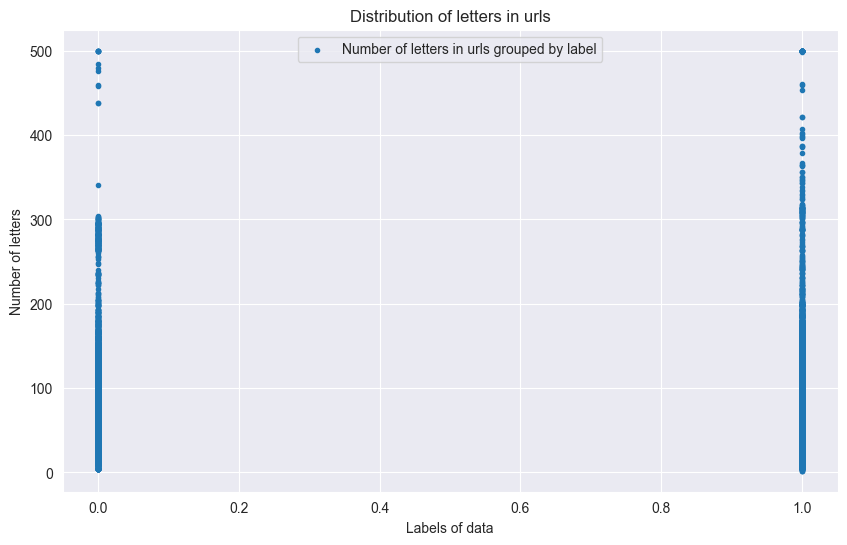

In [75]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['LETTERS_AMOUNT'], marker='.')
plt.title("Distribution of letters in urls")
plt.xlabel("Labels of data")
plt.ylabel("Number of letters")
plt.legend(['Number of letters in urls grouped by label'], loc='upper center')
plt.show()

### 5.10 Path Depth:

In [76]:
df_urls['PATH_DEPTH'] =  df_urls['URL'].apply(lambda url: FeatureExtraction(url).path_depth() if FeatureExtraction(url).path_depth() <= 30 else 30)

In [77]:
path_depth = df_urls[['URL', 'PATH_DEPTH']].groupby('PATH_DEPTH').count()
path_depth

,URL
PATH_DEPTH,
0,23164
1,17010
2,25663
3,16324
4,7114
5,5988
6,2220
7,1312
8,629


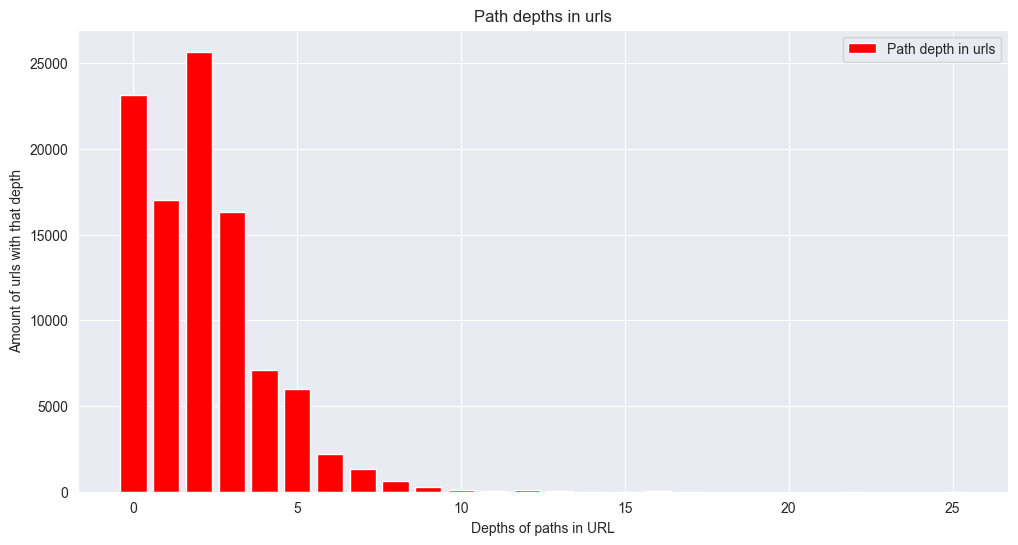

In [78]:
plt.figure(figsize=(12, 6))
plt.bar(path_depth.index, path_depth['URL'], color='r')
plt.title('Path depths in urls')
plt.xlabel('Depths of paths in URL')
plt.ylabel('Amount of urls with that depth')
plt.legend(['Path depth in urls'], loc='best')
plt.show()

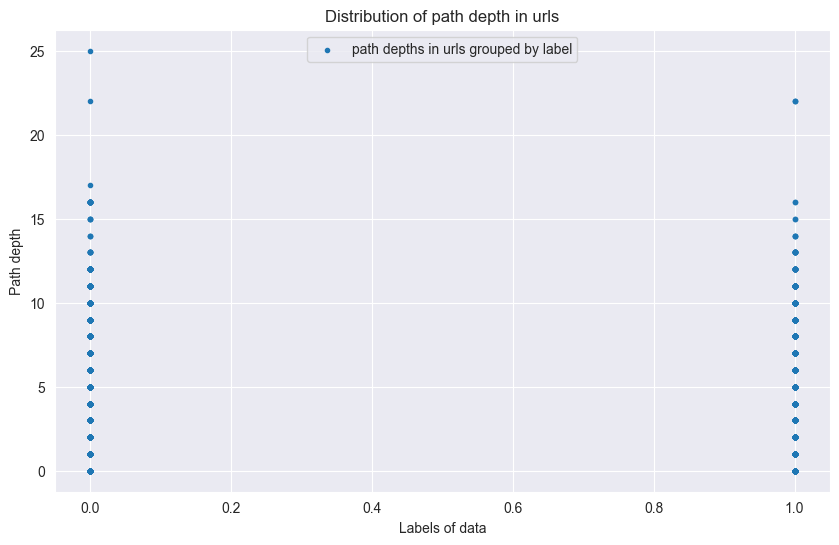

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['PATH_DEPTH'], marker='.')
plt.title("Distribution of path depth in urls")
plt.xlabel("Labels of data")
plt.ylabel("Path depth")
plt.legend(['path depths in urls grouped by label'], loc='upper center')
plt.show()

### 5.11 Dots in netloc:

In [80]:
df_urls['DOTS_IN_NETLOC'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).dots_in_netloc())

In [81]:
dots_in_netloc = df_urls[['URL', 'DOTS_IN_NETLOC']].groupby('DOTS_IN_NETLOC').count()
dots_in_netloc

,URL
DOTS_IN_NETLOC,
0,3720
1,44529
2,41163
3,8131
4,1117
5,442
6,234
7,117
8,59


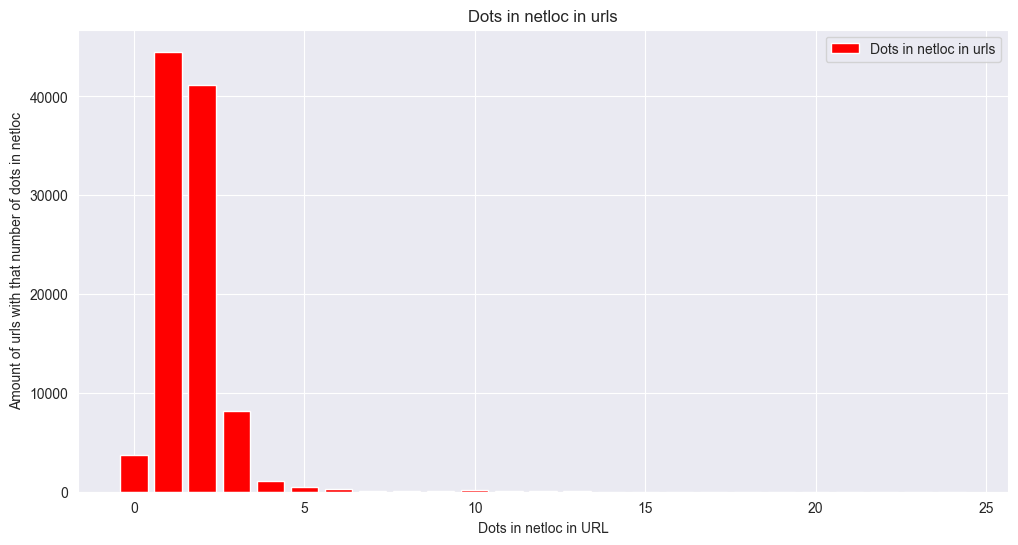

In [82]:
plt.figure(figsize=(12, 6))
plt.bar(dots_in_netloc.index, dots_in_netloc['URL'], color='r')
plt.title('Dots in netloc in urls')
plt.xlabel('Dots in netloc in URL')
plt.ylabel('Amount of urls with that number of dots in netloc')
plt.legend(['Dots in netloc in urls'], loc='best')
plt.show()

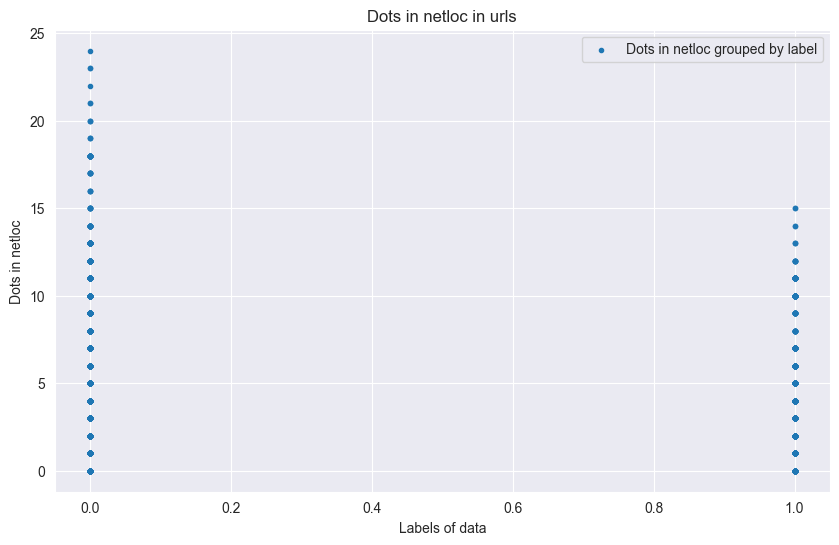

In [83]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['DOTS_IN_NETLOC'], marker='.')
plt.title('Dots in netloc in urls')
plt.xlabel("Labels of data")
plt.ylabel('Dots in netloc')
plt.legend(['Dots in netloc grouped by label'], loc='best')
plt.show()

### 5.12 Netloc length:

In [84]:
df_urls['NETLOC_LEN'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).netloc_length())

In [85]:
netloc_len = df_urls[['URL', 'NETLOC_LEN']].groupby('NETLOC_LEN').count()
netloc_len

,URL
NETLOC_LEN,
0,7
2,1
4,166
5,3920
6,683
...,...
234,1
236,2
238,1


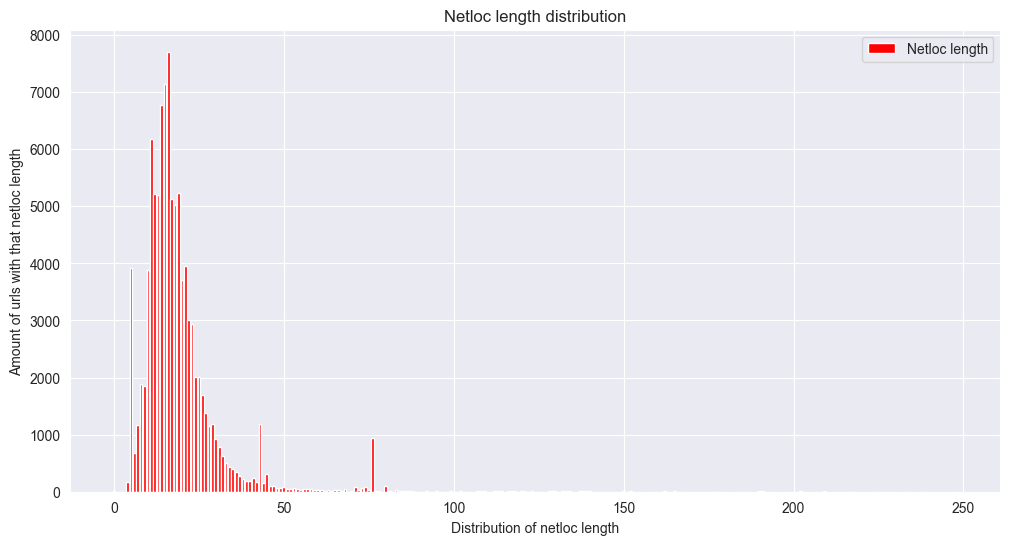

In [86]:
plt.figure(figsize=(12, 6))
plt.bar(netloc_len.index, netloc_len['URL'], color='r')
plt.title('Netloc length distribution')
plt.xlabel('Distribution of netloc length')
plt.ylabel('Amount of urls with that netloc length')
plt.legend(['Netloc length'], loc='best')
plt.show()

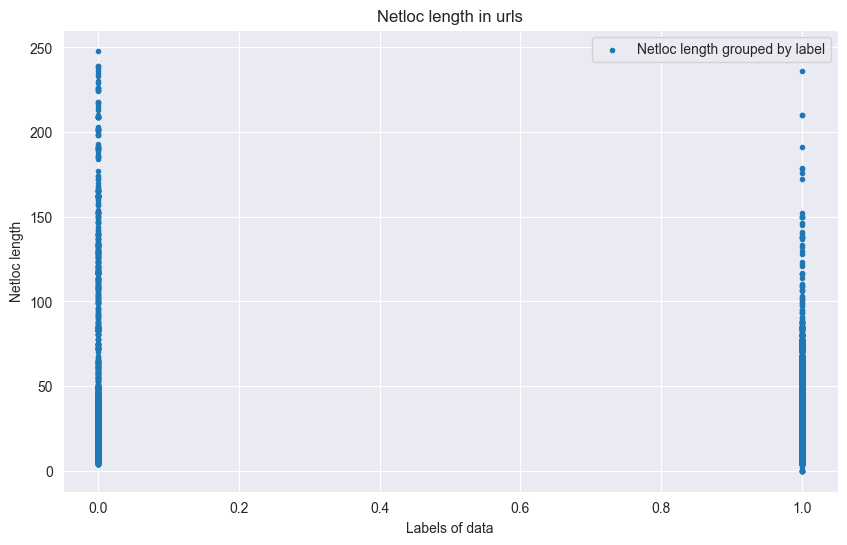

In [87]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['NETLOC_LEN'], marker='.')
plt.title('Netloc length in urls')
plt.xlabel("Labels of data")
plt.ylabel('Netloc length')
plt.legend(['Netloc length grouped by label'], loc='best')
plt.show()

### 5.13 Check if URL has shortening services pattern:

In [88]:
df_urls['HAVE_SHORTENING_PATTERNS'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_shortening_patterns() else 0)

In [89]:
df_urls[['URL', 'HAVE_SHORTENING_PATTERNS']].tail(20)

,URL,HAVE_SHORTENING_PATTERNS
99980,https://http://olx.ro/i2/electronice-si-electr...,0
99981,https://qrco.de/behOSK,0
99982,researchweb.watson.ibm.com/ecvg/biometrics.html,0
99983,http://mail.bebekidea.com/netbank/logon/login....,0
99984,https://web01.jetphotos.net/link/,0
99985,https://en.wikipedia.org/wiki/Dante_Cunningham,0
99986,https://ineffablemusic.com/hieroglyphics/site....,0
99987,https://last.fm/music/Cobra+Starship/_/Wet+Hot...,0
99988,https://www.groovy-lang.org,0
99989,sites.google.com/site/butterworthconsulting/,0


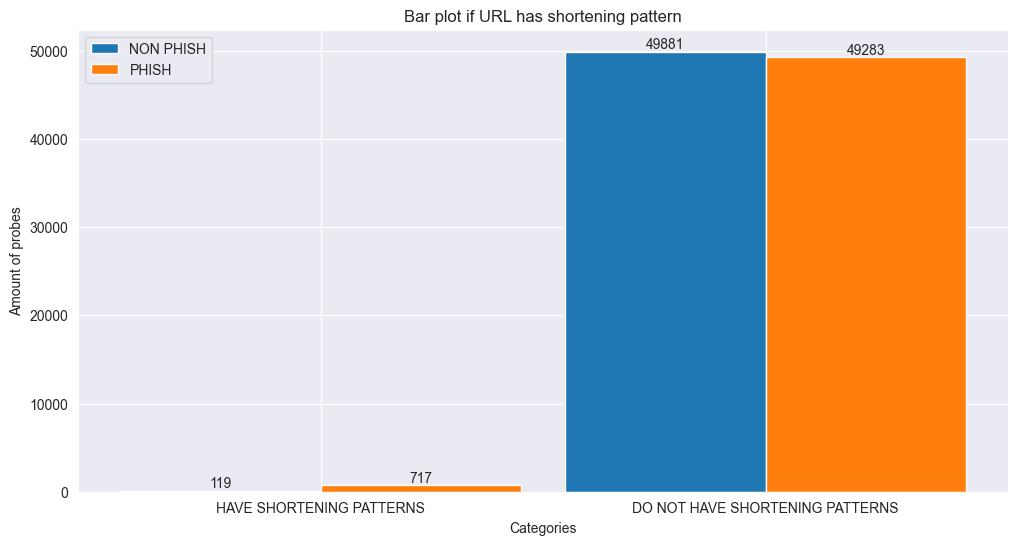

In [90]:
# Filter results
legitimate_and_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 0) & (df_urls['label'] == 0)
phish_and_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 1) & (df_urls['label'] == 1)
phish_and_not_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_shortening_pattern_filter]), len(df_urls[legitimate_and_not_shortening_pattern_filter])]
values2 = [len(df_urls[phish_and_shortening_pattern_filter]), len(df_urls[phish_and_not_shortening_pattern_filter])]

PlotTwoCat(
    positive_cat='HAVE SHORTENING PATTERNS',
    negative_cat='DO NOT HAVE SHORTENING PATTERNS',
    title='Bar plot if URL has shortening pattern',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

### 5.14 Check if URL has JavaScript code:

In [91]:
df_urls['HAVE_JS_CODE'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_javascript_code() else 0)

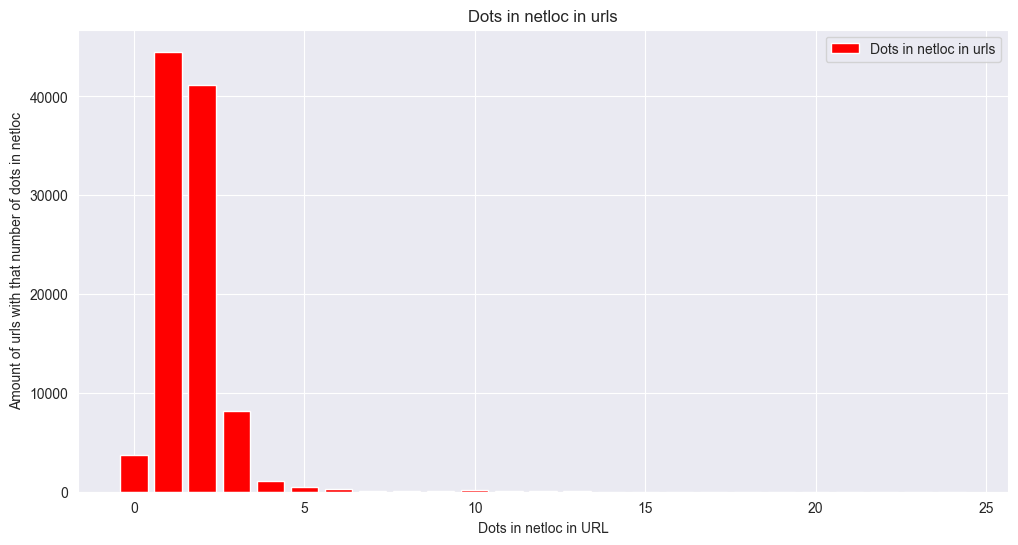

In [92]:
plt.figure(figsize=(12, 6))
plt.bar(dots_in_netloc.index, dots_in_netloc['URL'], color='r')
plt.title('Dots in netloc in urls')
plt.xlabel('Dots in netloc in URL')
plt.ylabel('Amount of urls with that number of dots in netloc')
plt.legend(['Dots in netloc in urls'], loc='best')
plt.show()

In [93]:
df_urls.head()

,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,"""",HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE
0,382344,https://http://hollywoodlife.com/2015/05/13/ju...,0,98,0,1,0,0,0,0,...,0,1,1,8,72,7,0,5,0,0
1,111770,www.jbviande.com/uk/default.asp,1,31,0,0,0,0,0,0,...,0,0,1,0,26,2,2,16,0,0
2,118650,www.igi-pub.com/journals/details.asp?id=198,1,43,0,0,0,0,0,0,...,0,0,1,3,32,2,2,15,0,0
3,339406,https://encycl.opentopia.com/G/GI/GIL,0,37,0,0,0,0,0,0,...,0,1,0,0,29,3,2,20,0,0
4,61576,paypal.com.ecoteh.org,1,21,0,0,0,0,0,0,...,0,0,1,0,18,0,3,21,0,0


### 5.15 Check if URL has www. prefix in netloc:

In [94]:
df_urls['HAVE_WWW_PREFIX'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_www_in_netloc() else 0)

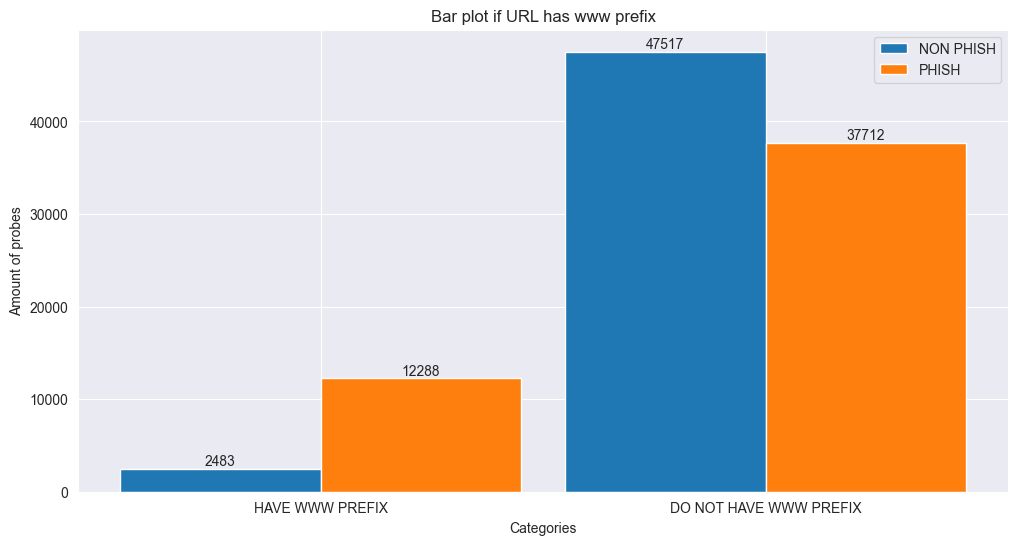

In [95]:
# Filter results
legitimate_and_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 0) & (df_urls['label'] == 0)
phish_and_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 1) & (df_urls['label'] == 1)
phish_and_not_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_have_www_filter]), len(df_urls[legitimate_and_not_have_www_filter])]
values2 = [len(df_urls[phish_and_have_www_filter]), len(df_urls[phish_and_not_have_www_filter])]

PlotTwoCat(
    positive_cat='HAVE WWW PREFIX',
    negative_cat='DO NOT HAVE WWW PREFIX',
    title='Bar plot if URL has www prefix',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

In [96]:
df_urls

,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE,HAVE_WWW_PREFIX
0,382344,https://http://hollywoodlife.com/2015/05/13/ju...,0,98,0,1,0,0,0,0,...,1,1,8,72,7,0,5,0,0,0
1,111770,www.jbviande.com/uk/default.asp,1,31,0,0,0,0,0,0,...,0,1,0,26,2,2,16,0,0,1
2,118650,www.igi-pub.com/journals/details.asp?id=198,1,43,0,0,0,0,0,0,...,0,1,3,32,2,2,15,0,0,1
3,339406,https://encycl.opentopia.com/G/GI/GIL,0,37,0,0,0,0,0,0,...,1,0,0,29,3,2,20,0,0,0
4,61576,paypal.com.ecoteh.org,1,21,0,0,0,0,0,0,...,0,1,0,18,0,3,21,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,59503,https://bafybeicny6wvjulotaburyrkd4jao2gltxipx...,1,90,0,1,0,0,0,0,...,1,0,5,77,1,3,73,0,0,0
99996,92472,http://u722323ssw.ha004.t.justns.ru/dossier/,1,44,0,0,0,0,0,0,...,0,0,9,26,2,4,28,0,0,0
99997,57325,https://toaconsulting.com/rcu.org/,1,34,0,0,0,0,0,0,...,1,0,0,27,2,1,17,0,0,0
99998,176383,https://uky.edu/KentuckyAtlas/21111.html,0,40,0,0,0,0,0,0,...,1,0,5,28,2,1,7,0,0,0


### 5.16 Count Number of / in path (commented because the redundancy of the parameter):

In [97]:
# df_urls['NUMBER_OF_SLASHES_IN_PATH'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_slashes_in_path())

In [98]:
# number_of_slashes_in_path = df_urls[['URL', 'NUMBER_OF_SLASHES_IN_PATH']].groupby('NUMBER_OF_SLASHES_IN_PATH').count()
# number_of_slashes_in_path

In [99]:
# plt.figure(figsize=(12, 6))
# plt.bar(number_of_slashes_in_path.index, number_of_slashes_in_path['URL'], color='r')
# plt.title('Slashes number distribution')
# plt.xlabel('Distribution of slashes in path')
# plt.ylabel('Amount of urls with that number of slashes')
# plt.legend(['Slashes number'], loc='best')
# plt.show()

### 5.17 Count Number of words in netloc:

In [100]:
df_urls['NUMBER_OF_WORDS_IN_NETLOC'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_words_in_netloc())

In [101]:
number_of_words_in_netloc = df_urls[['URL', 'NUMBER_OF_WORDS_IN_NETLOC']].groupby('NUMBER_OF_WORDS_IN_NETLOC').count()
number_of_words_in_netloc

,URL
NUMBER_OF_WORDS_IN_NETLOC,
1,3720
2,44529
3,41163
4,8131
5,1117
6,442
7,234
8,117
9,59


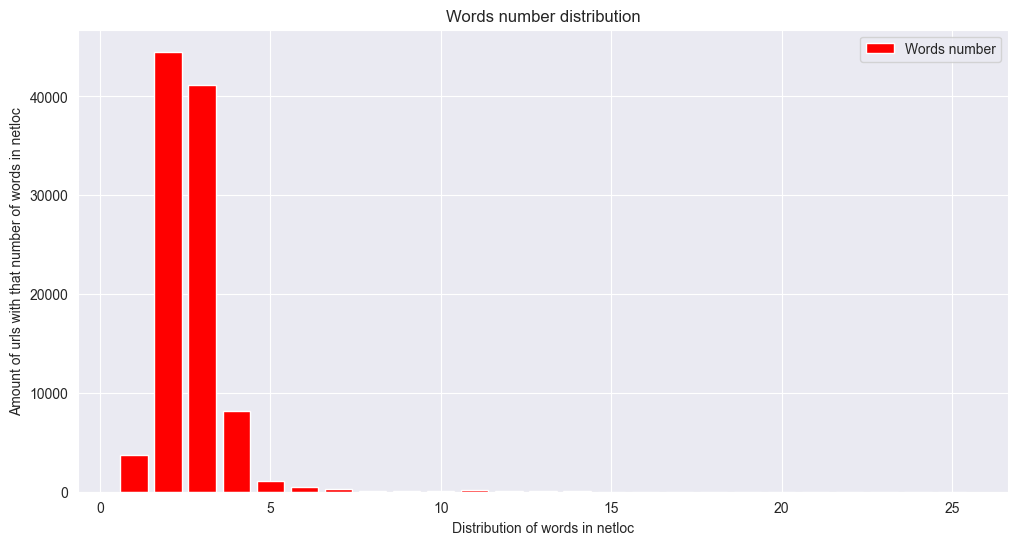

In [102]:
plt.figure(figsize=(12, 6))
plt.bar(number_of_words_in_netloc.index, number_of_words_in_netloc['URL'], color='r')
plt.title('Words number distribution')
plt.xlabel('Distribution of words in netloc')
plt.ylabel('Amount of urls with that number of words in netloc')
plt.legend(['Words number'], loc='best')
plt.show()

W## 6. Learn models

### 6.1 Drop unnecessary or zero columns:

In [103]:
df_urls = df_urls.sample(frac=1)
df_urls1 = df_urls.drop(['OLD_INDEX', 'URL'], axis=1)

In [104]:
df_urls_unique = df_urls1.drop_duplicates()
df_urls_unique

,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,...,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
46467,1,30,0,0,0,0,0,0,0,0,...,1,4,22,1,2,18,0,0,1,3
69470,1,505,0,1,0,0,0,0,6,0,...,0,129,356,1,2,30,0,0,0,3
88086,0,34,0,0,0,0,0,0,0,0,...,0,0,28,0,3,26,0,0,0,4
9733,1,24,0,0,0,0,0,0,0,0,...,1,1,21,0,1,24,0,0,0,2
11797,1,39,0,0,0,0,0,0,0,0,...,1,1,33,3,2,17,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79541,0,186,0,1,0,0,0,0,0,0,...,0,6,148,4,1,11,0,0,0,2
16965,0,90,0,1,0,0,0,0,1,0,...,0,3,71,3,2,20,0,0,0,3
53524,0,72,0,1,0,0,0,0,0,0,...,0,0,62,1,1,18,0,0,0,2
73995,1,36,0,0,0,0,0,0,0,0,...,1,8,24,1,2,16,0,0,1,3


In [105]:
df_not_duplicated = df_urls_unique.groupby('label').count()
df_not_duplicated

,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,&,...,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
label,,,,,,,,,,,,,,,,,,,,,
0,32590,32590,32590,32590,32590,32590,32590,32590,32590,32590,...,32590,32590,32590,32590,32590,32590,32590,32590,32590,32590
1,24763,24763,24763,24763,24763,24763,24763,24763,24763,24763,...,24763,24763,24763,24763,24763,24763,24763,24763,24763,24763


In [106]:
min_unique_label = df_not_duplicated['URL_LENGTH'].values.min()
min_unique_label

24763

In [107]:
columns_to_drop = []
for col in df_urls_unique.columns:
    if df_urls_unique[col].sum() == 0:
        columns_to_drop.append(col)
        
df_urls_unique.drop(columns=columns_to_drop, axis=1, inplace=True)
df_urls_unique.columns

/var/folders/zm/tm20ygt57kq58xczfpbpf6dc0000gn/T/ipykernel_67176/1171642888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urls_unique.drop(columns=columns_to_drop, axis=1, inplace=True)


Index(['label', 'URL_LENGTH', 'HAVE_IP', 'LONGER_THAN_MEAN', '!', '@', '#',
       '$', '%', '^', '&', '*', '(', ')', '{', '}', '[', ']', '~', '`', ':',
       ';', '|', '\', ',', '.', '<', '>', '?', '/', '+', '=', '-', '_', ''',
       '"', 'HAVE_HTTPS', 'ABNORMAL_URL', 'DIGITS_AMOUNT', 'LETTERS_AMOUNT',
       'PATH_DEPTH', 'DOTS_IN_NETLOC', 'NETLOC_LEN',
       'HAVE_SHORTENING_PATTERNS', 'HAVE_WWW_PREFIX',
       'NUMBER_OF_WORDS_IN_NETLOC'],
      dtype='object')

In [108]:
negatives = df_urls_unique[df_urls_unique['label'] == 0].sample(min_unique_label)
positives = df_urls_unique[df_urls_unique['label'] == 1].sample(min_unique_label)

In [109]:
df_final = pd.concat([positives, negatives])
df_final = df_final.sample(len(df_final))
df_final

,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,...,HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
20392,1,35,0,0,0,0,0,0,0,0,...,0,0,0,27,1,2,18,0,0,3
33941,0,51,0,0,0,0,0,0,0,0,...,1,0,5,35,4,1,9,0,0,2
96869,1,32,0,0,0,0,0,0,0,0,...,0,1,0,28,2,2,23,0,1,3
25343,1,47,0,0,0,0,0,0,0,0,...,1,0,0,40,2,1,17,0,0,2
58601,1,27,0,0,0,0,0,0,0,0,...,0,0,3,18,1,1,11,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29300,0,71,0,1,0,0,0,0,0,0,...,1,0,0,60,3,1,18,0,0,2
27431,1,23,0,0,0,0,0,0,0,0,...,0,1,0,19,2,2,16,0,0,3
96466,1,34,0,0,0,0,0,0,0,0,...,0,0,4,22,0,3,27,0,0,4
31890,0,45,0,0,0,0,0,0,0,0,...,1,0,0,39,1,1,21,0,0,2


In [110]:
X = df_final.drop(['label'], axis=1)
y = df_final['label']

In [111]:
X

,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,%,^,&,...,HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_WWW_PREFIX,NUMBER_OF_WORDS_IN_NETLOC
20392,35,0,0,0,0,0,0,0,0,0,...,0,0,0,27,1,2,18,0,0,3
33941,51,0,0,0,0,0,0,0,0,0,...,1,0,5,35,4,1,9,0,0,2
96869,32,0,0,0,0,0,0,0,0,0,...,0,1,0,28,2,2,23,0,1,3
25343,47,0,0,0,0,0,0,0,0,0,...,1,0,0,40,2,1,17,0,0,2
58601,27,0,0,0,0,0,0,0,0,0,...,0,0,3,18,1,1,11,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29300,71,0,1,0,0,0,0,0,0,0,...,1,0,0,60,3,1,18,0,0,2
27431,23,0,0,0,0,0,0,0,0,0,...,0,1,0,19,2,2,16,0,0,3
96466,34,0,0,0,0,0,0,0,0,0,...,0,0,4,22,0,3,27,0,0,4
31890,45,0,0,0,0,0,0,0,0,0,...,1,0,0,39,1,1,21,0,0,2


In [112]:
y

20392    1
33941    0
96869    1
25343    1
58601    1
        ..
29300    0
27431    1
96466    1
31890    0
77114    0
Name: label, Length: 49526, dtype: int64

In [113]:
print(X.columns.shape)
X.columns

(45,)


Index(['URL_LENGTH', 'HAVE_IP', 'LONGER_THAN_MEAN', '!', '@', '#', '$', '%',
       '^', '&', '*', '(', ')', '{', '}', '[', ']', '~', '`', ':', ';', '|',
       '\', ',', '.', '<', '>', '?', '/', '+', '=', '-', '_', ''', '"',
       'HAVE_HTTPS', 'ABNORMAL_URL', 'DIGITS_AMOUNT', 'LETTERS_AMOUNT',
       'PATH_DEPTH', 'DOTS_IN_NETLOC', 'NETLOC_LEN',
       'HAVE_SHORTENING_PATTERNS', 'HAVE_WWW_PREFIX',
       'NUMBER_OF_WORDS_IN_NETLOC'],
      dtype='object')

In [114]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49526 entries, 20392 to 77114
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   URL_LENGTH                 49526 non-null  int64
 1   HAVE_IP                    49526 non-null  int64
 2   LONGER_THAN_MEAN           49526 non-null  int64
 3   !                          49526 non-null  int64
 4   @                          49526 non-null  int64
 5   #                          49526 non-null  int64
 6   $                          49526 non-null  int64
 7   %                          49526 non-null  int64
 8   ^                          49526 non-null  int64
 9   &                          49526 non-null  int64
 10  *                          49526 non-null  int64
 11  (                          49526 non-null  int64
 12  )                          49526 non-null  int64
 13  {                          49526 non-null  int64
 14  }                      

In [115]:
y.head()

20392    1
33941    0
96869    1
25343    1
58601    1
Name: label, dtype: int64

### 6.2 Split probes into train, validate and test sets

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test,  = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"X_train shape: {X_train.shape} - Percentage: {X_train.shape[0] / X.shape[0] * 100}%")
print(f"X_val shape: {X_val.shape} - Percentage: {X_val.shape[0] / X.shape[0] * 100}%")
print(f"X_test shape: {X_test.shape} - Percentage: {X_test.shape[0] / X.shape[0] * 100}%")
print(f"y_train shape: {y_train.shape} - Percentage: {y_train.shape[0] / y.shape[0] * 100}%")
print(f"y_val shape: {y_val.shape} - Percentage: {y_val.shape[0] / y.shape[0] * 100}%")
print(f"y_test shape: {y_test.shape} - Percentage: {y_test.shape[0] / y.shape[0] * 100}%")

X_train shape: (29715, 45) - Percentage: 59.998788515123366%
X_val shape: (9905, 45) - Percentage: 19.99959617170779%
X_test shape: (9906, 45) - Percentage: 20.00161531316884%
y_train shape: (29715,) - Percentage: 59.998788515123366%
y_val shape: (9905,) - Percentage: 19.99959617170779%
y_test shape: (9906,) - Percentage: 20.00161531316884%


### 6.3 Configure parameters:

In [117]:
best_accuracy_random_state = 0
best_accuracy_n_estimators = 0
best_max_depth = 0
best_accuracy = 0
MIN_RANGE = 0
MAX_RANGE = 200
HOP = 20
best_model1 = None

### 6.4 Random Forest Classifier:

In [118]:
# RandomForestClassifier
# for n_trees in range(MIN_RANGE + 1, 150, HOP):
#     for state in range(MIN_RANGE + 1, MAX_RANGE, HOP):
#         for max_depth in range(10, 40, 5):
#             pipeline = Pipeline([
#             ('scaler', MinMaxScaler()),
#             ('classifier', RandomForestClassifier(random_state=state, n_estimators=state, max_depth=max_depth))
#             ])
#             pipeline.fit(X_train, y_train)
#             y_pred = pipeline.predict(X_val)
#             accuracy = accuracy_score(y_val, y_pred)
#             if best_accuracy < accuracy:
#                 best_accuracy_random_state = state
#                 best_accuracy_n_estimators = n_trees
#                 best_max_depth = max_depth
#                 best_accuracy = accuracy
#                 best_model = pipeline
#             print(f"Accuracy of random state {state} and n-trees: {n_trees}: {accuracy} and max depth: {best_max_depth}")
# 
# print(f"Best accuracy: {best_accuracy} - random state: {best_accuracy_random_state} - best n estimators: {best_accuracy_n_estimators}")


In [144]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(n_estimators=21, max_depth=20))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
logloss = log_loss(y_test, y_pred)


In [145]:
the_best_model = pipeline

In [146]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # probability for label 1
auc = roc_auc_score(y_test, y_pred_prob)


In [147]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

Accuracy: 0.9131839289319604
Precision: [0.89219401 0.93712187]
Recall: [0.9418     0.88401957]
F1 Score: [0.91632613 0.90979652]
Log Loss: 3.12916837418138
AUC: 0.9743490623726048


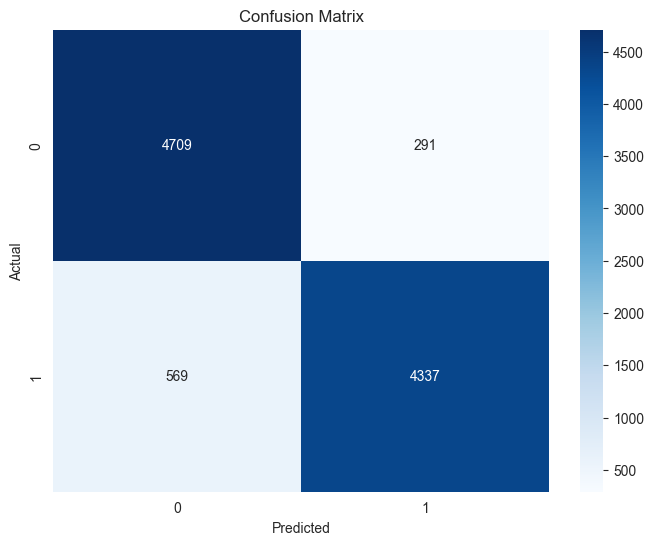

In [148]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

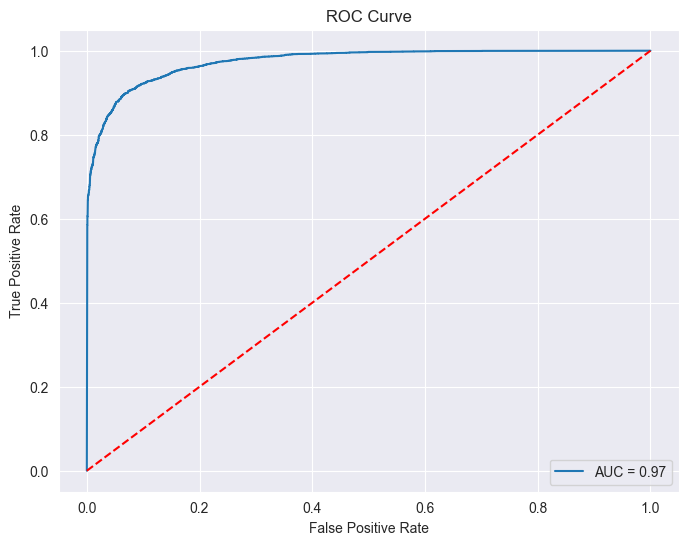

In [149]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [125]:
# with open(os.path.join('saved_models', 'random_forest_model'), mode='wb') as file_handler:
#     pickle.dump(best_model1, file_handler)

Best accuracy: 0.92965 - random state: 201

### 6.5 Extra Trees Classifier:

In [126]:
# best_accuracy_random_state2 = 0
# best_accuracy_n_estimators2 = 0
# best_accuracy2 = 0
# best_model2 = None
# for state in range(1, 20, 5):
#     for n_estimators in range(10, 151, 10):
#         pipeline = Pipeline([
#         ('scaler', MinMaxScaler()),
#         ('classifier', ExtraTreesClassifier(random_state=state, n_estimators=n_estimators, max_depth=50))
#         ])
# 
#         pipeline.fit(X_train, y_train)
#         y_pred_extra_trees = pipeline.predict(X_val)
#         accuracy = accuracy_score(y_val, y_pred_extra_trees)
#         if best_accuracy < accuracy:
#             best_accuracy_random_state = state
#             best_accuracy = accuracy
#             best_model = pipeline
#         print(f"Accuracy of random state {state}: {accuracy}")
# 
# print(f"Best accuracy: {best_accuracy} - random state: {best_accuracy_random_state} - best accuracy: {best_accuracy_n_estimators}")

In [127]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', ExtraTreesClassifier(random_state=16, n_estimators=120, max_depth=20))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

In [128]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # probability for label 1
auc = roc_auc_score(y_test, y_pred_prob)

In [129]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

Accuracy: 0.8964264082374318
Precision: 0.949698655540102
Recall: 0.8350998777007745
F1 Score: 0.8887201735357918
Log Loss: 3.733170641755926
AUC: 0.9661621076233183


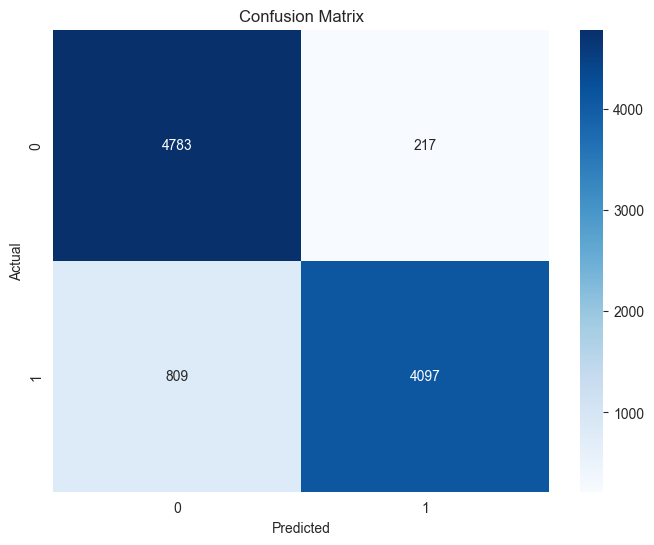

In [130]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

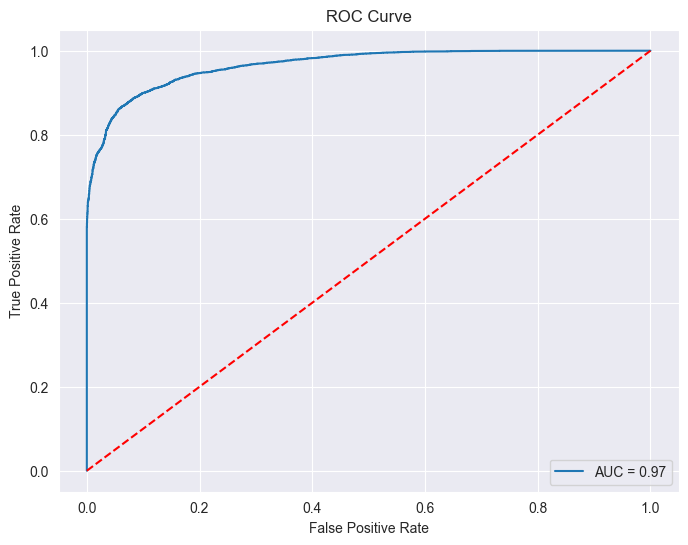

In [131]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.6 Logistic Regression:

In [132]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', C=1.0))
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression())])

In [133]:
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)

In [134]:
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]  # probability for label 1
auc = roc_auc_score(y_test, y_pred_prob)

In [135]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

Accuracy: 0.8366646476882698
Precision: 0.9379328716036228
Recall: 0.7176926212800653
F1 Score: 0.8131639722863742
Log Loss: 5.887202824913341
AUC: 0.9294729514879738


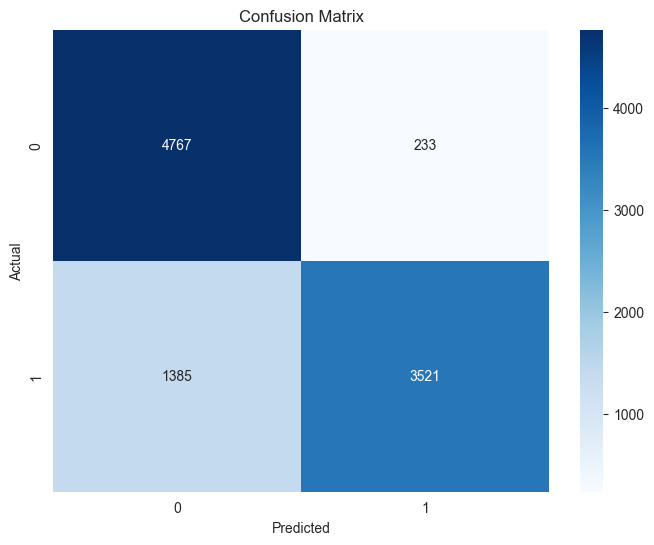

In [136]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

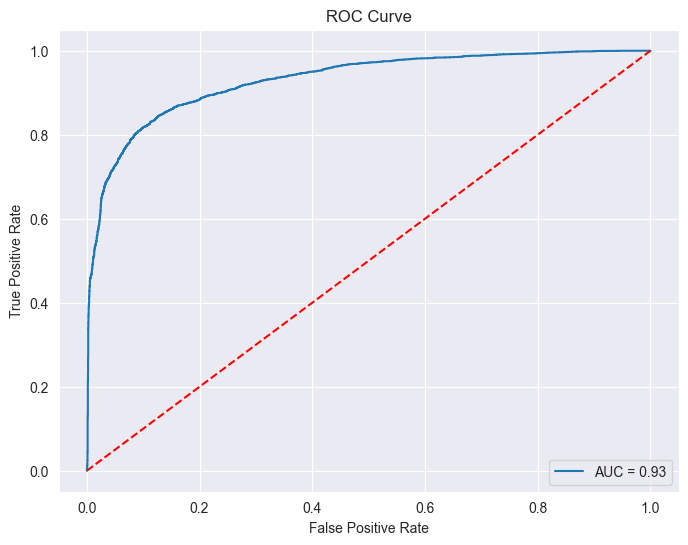

In [137]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.6 Support Vector Machines (SVM):

Accuracy: 0.8267716535433071
Precision: 0.9485376827896513
Recall: 0.6875254790052996
F1 Score: 0.7972110612148429
Log Loss: 6.24378247685494
AUC: 0.9269266000815328


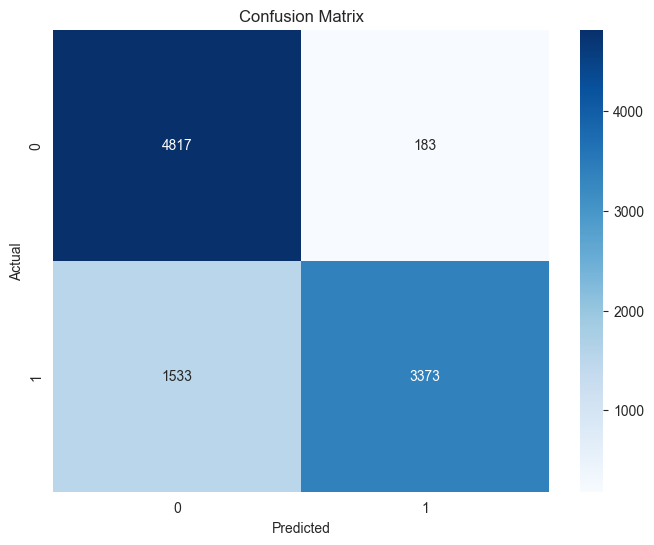

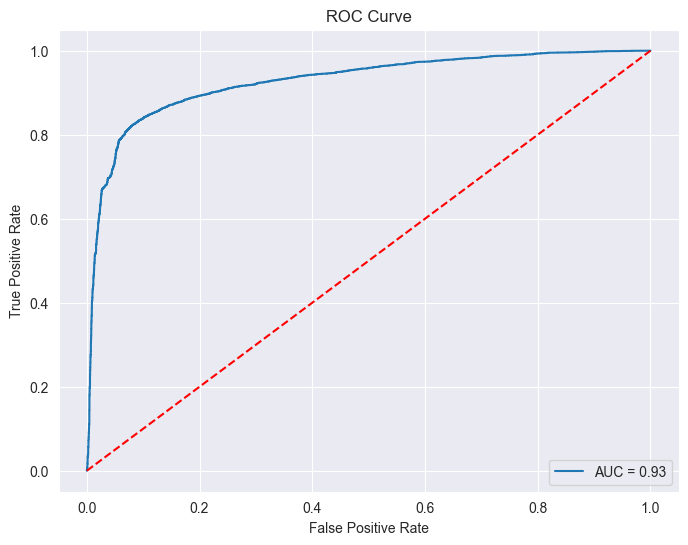

In [138]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', SVC(kernel='linear', C=1.0, probability=True, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.7  K-Nearest Neighbors (KNN):

Accuracy: 0.9096507167373309
Precision: 0.9351269255803862
Recall: 0.8785161027313494
F1 Score: 0.905937992643195
Log Loss: 3.256518249874808
AUC: 0.9683505707297186


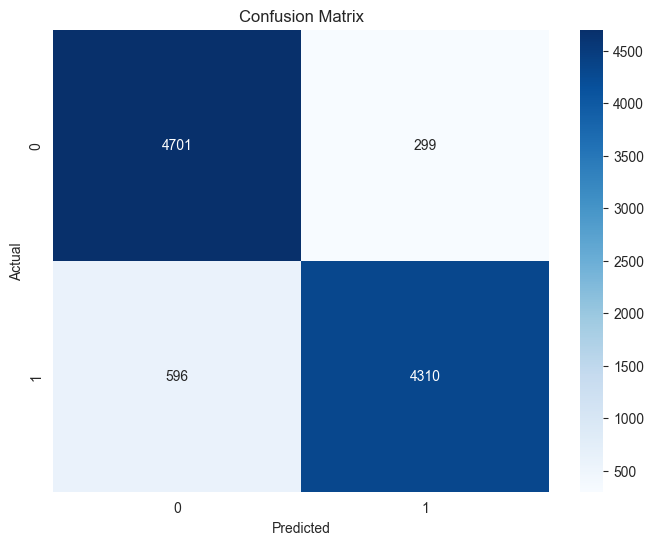

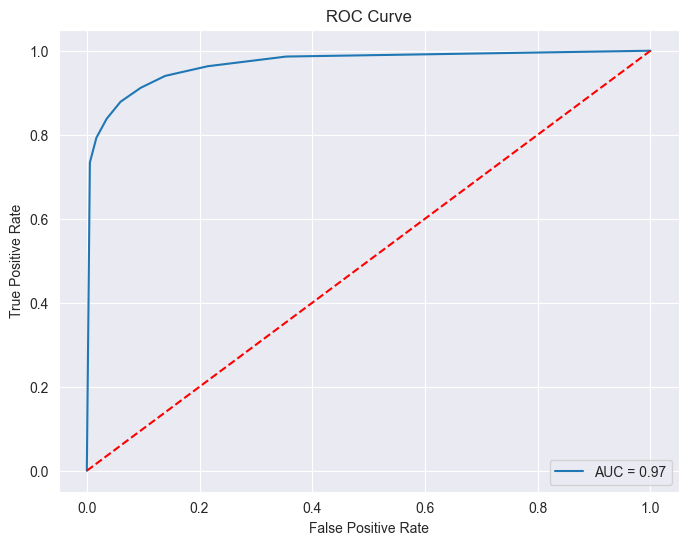

In [139]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=8))
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.8 Naive Bayes:

Accuracy: 0.6496062992125984
Precision: 0.972972972972973
Recall: 0.30085609457806767
F1 Score: 0.459598318542737
Log Loss: 12.629469100911127
AUC: 0.9041331227068896


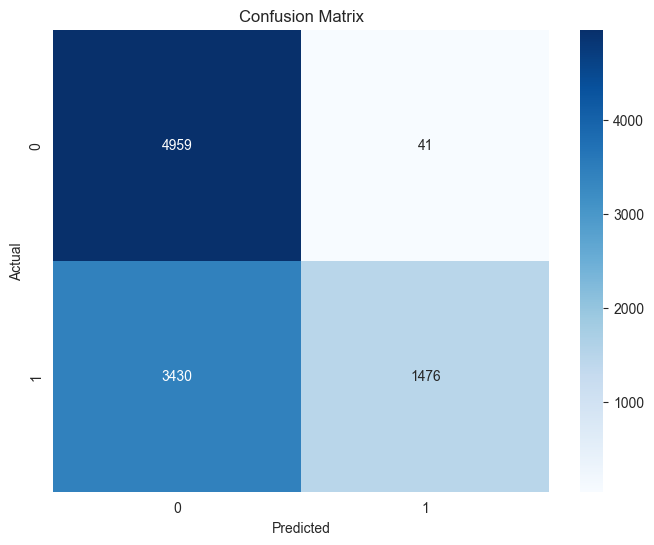

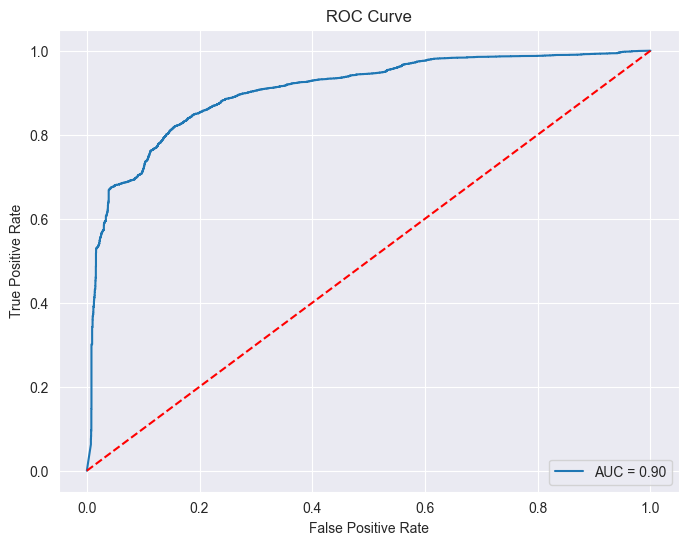

In [140]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', GaussianNB())
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.9 Gradient Boosting:

Accuracy: 0.8978396931152837
Precision: 0.9361559139784946
Recall: 0.8518141051773339
F1 Score: 0.8919957310565635
Log Loss: 3.6822306914785545
AUC: 0.963364023644517


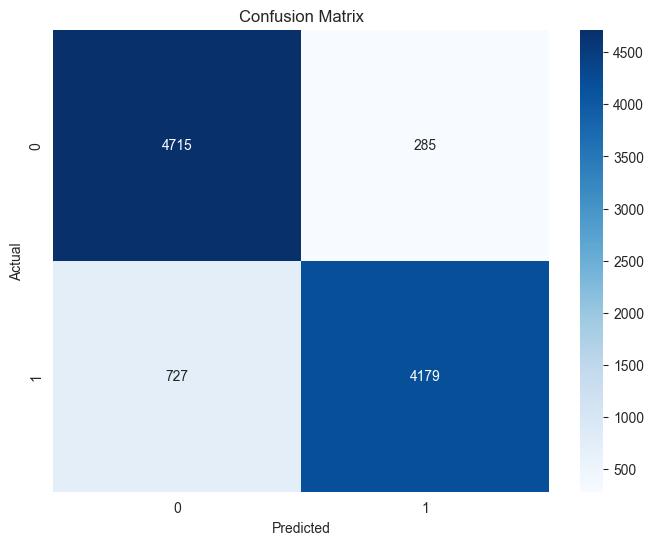

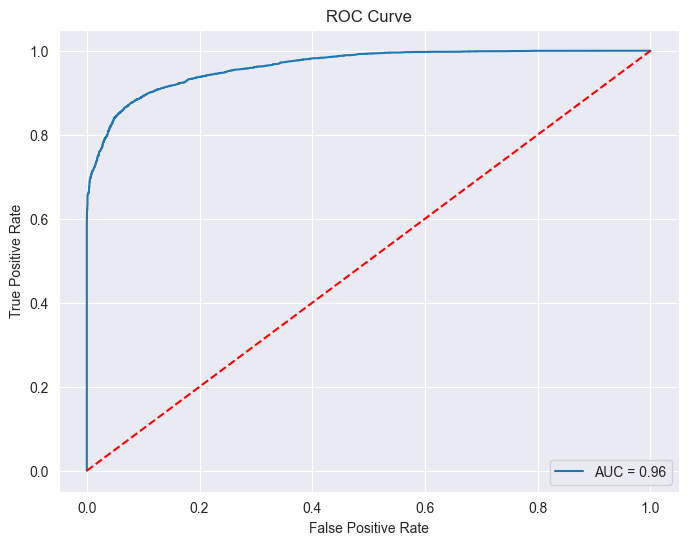

In [141]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

svm_pipeline.fit(X_train, y_train)
y_pred = svm_pipeline.predict(X_test)
y_pred_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # probability for label 1

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.10 Multilayer Perceptron:

In [142]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
input_shape = (X_train.shape[1], )

In [143]:
model = keras.Sequential([
    keras.Input(shape=input_shape),
    Dense(256, activation='relu', name='l1'),
    Dense(256, activation='relu', name='l2'),
    Dense(256, activation='relu', name='l3'),
    Dense(128, activation='relu', name='l4'),
    Dense(128, activation='relu', name='l5'),
    Dense(64, activation='relu', name='l6'),
    Dense(32, activation='relu', name='l7'),
    Dense(1, activation='sigmoid', name='output_layer')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

X_val_scaled = scaler.fit_transform(X_test)
history = model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_data=(X_val_scaled, y_val))

Epoch 1/30
927/929 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8515 - auc: 0.9150 - loss: 0.3451 - precision: 0.9141 - recall: 0.7801

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 9906
'y' sizes: 9905


In [ ]:
X_test_scaled = scaler.fit_transform(X_test)
y_pred_prob = model.predict(X_test_scaled).ravel()  
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("AUC:", auc)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### 6.11 Save Best Model:

In [151]:
with open(os.path.join('saved_models', 'rf_model_random.pkl'), mode='wb') as file_handler:
    pickle.dump(the_best_model, file_handler)

### 6.12 Load Best Model

In [ ]:
# with open(os.path.join('saved_models', 'random_forest_model_params_best'), mode='rb') as file_handler:
#     model = pickle.load(file_handler)